In [1]:
import sys
import os
sys.path.insert(0, '../icenumerics')
import icenumerics as ice
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm.notebook as tqdm

ureg = ice.ureg

from importlib import reload  
import shakti as sha
reload(sha)

from icenumerics.geometry import ordering 

%load_ext autoreload
%autoreload 2

# Simulation Shakti lattice

In this script, I will summarize the code needed to obtain the output for the shakti simulations. This is a previous step for having a script with parallel simulations.

In [2]:
output = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-11.0"

In [3]:
trap_sep = 10 # Short trap
radius = 5
distance = 3
interparticle_distance = 2*radius + distance # distance among a particle next to the other 
part_d = interparticle_distance*np.cos(np.pi/4) # distance among a particle in front of the other 
plaquette_cte = part_d*4+2*trap_sep

In [4]:
sp = sha.spins()
ureg = ice.ureg

sp.create_lattice(geometry = "shakti",size =[10,10],lattice_constant=plaquette_cte*ureg.um , border="periodic")
sp.order_spins(ordering.random_ordering)

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/shakti.py:251: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


In [5]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap_short = ice.trap(trap_sep = 10*ureg.um,
               height = 25*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

trap_long = ice.trap(trap_sep =(20+13*np.sqrt(2))*ureg.um,
               height = 25*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

In [6]:
traps = []

for s in sp:
    
    if ( s.direction[0].magnitude >= plaquette_cte or s.direction[0].magnitude <= -plaquette_cte or 
        s.direction[1].magnitude >= plaquette_cte or s.direction[1].magnitude <= -plaquette_cte):
        
        traps.append(trap_long)
        
    else:
        
        traps.append(trap_short)

In [7]:
col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(5*ureg.um)

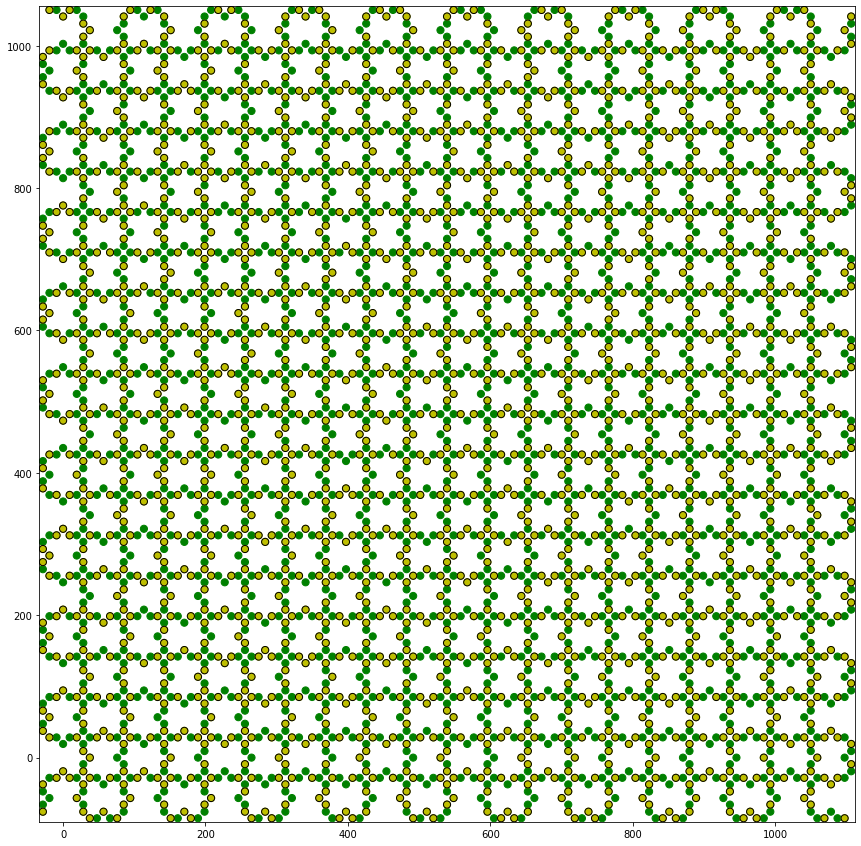

In [8]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))

col.display(ax1)

In [9]:
world = ice.world(
    field = 25*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)
#   boundaries = ["p", "p", "p"])

In [10]:
change_m_time = 2000*ureg.s
total_time = 2500*ureg.s
col.simulate(world,
             name = "shakti_10x10_25mT-TEST",
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

../icenumerics/icenumerics/magcolloids/magcolloids/geometry.py:13: RuntimeWarning: invalid value encountered in multiply
  c = np.empty([len(a),4])*np.NaN


scanning file


In [11]:
col.sim.field.fieldz = "(time<2000000000)*v_Bmag*time/%f+(time>=2000000000)*v_Bmag"%(change_m_time.to(ureg.us).magnitude)
col.run_simulation() 

In [12]:
# Is it necessary if I infer the vertices charge and other information from the col object. 
# Check if it is essential! 
#col.load_simulation(slice(0,None,10))

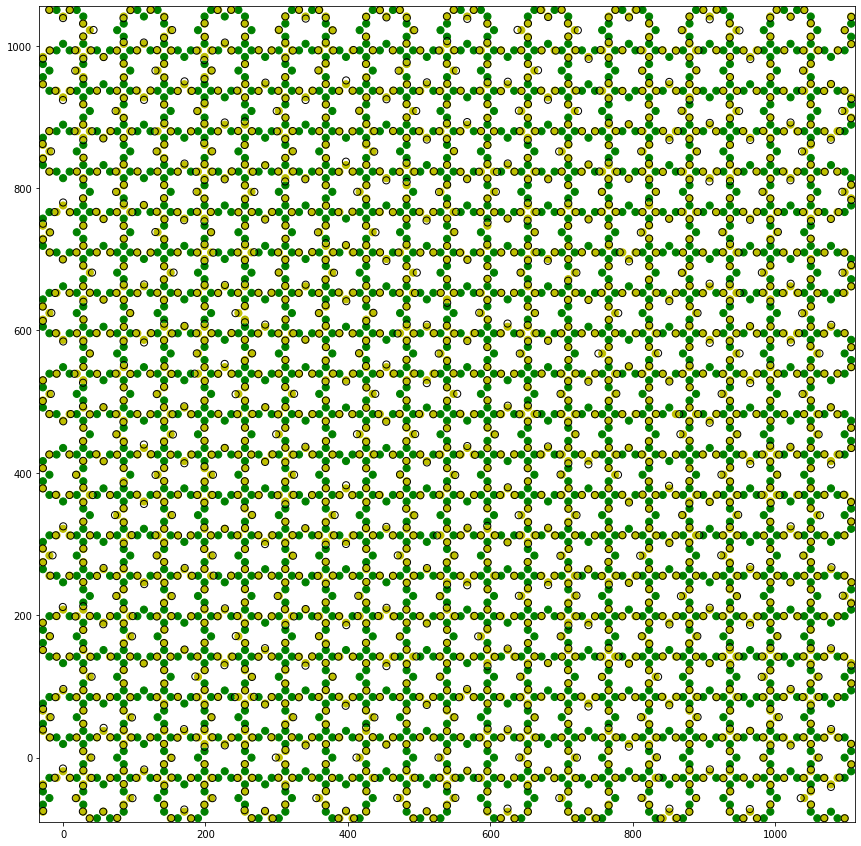

In [13]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))

col.set_state_from_frame(5)
col.display(ax1)

In [14]:
edges_shakti_values = pd.read_csv('edges_shakti_10x10.dat')
vertices = pd.read_csv('vertices_shakti_10x10.dat')

In [15]:
v_non_inferred = ice.vertices(
    positions = vertices[["x","y"]].values,
    edges = edges_shakti_values[["start","stop"]].values)

In [38]:
col.set_state_from_frame(0)

 ...]

In [39]:
v_non_inferred.update_directions(col)

In [40]:
v_non_inferred.classify_vertices(ice.ice_to_spins(col))

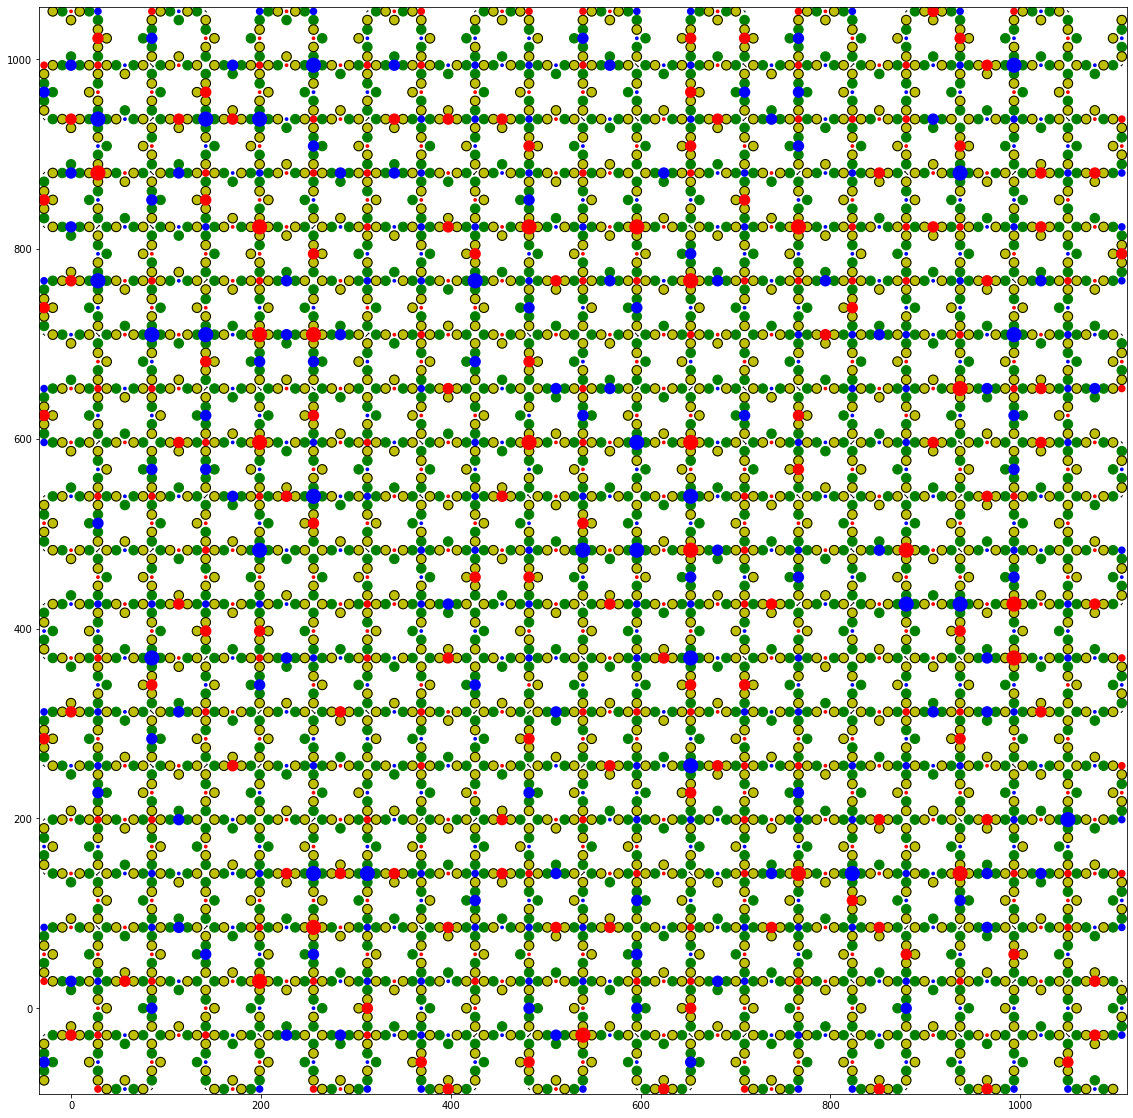

In [41]:
f, (ax1) = plt.subplots(1,1,figsize = (20,20))

col.display(ax1)
v_non_inferred.display(ax1)
#plt.savefig('shakti_end')

In [42]:
v_non_inferred.vertices.groupby('charge').count()

,x,y,coordination,dx,dy
charge,,,,,
-4,26,26,26,26,26
-3,91,91,91,91,91
-2,124,124,124,124,124
-1,290,290,290,290,290
0,166,166,166,166,166
1,315,315,315,315,315
2,100,100,100,100,100
3,104,104,104,104,104
4,21,21,21,21,21


In [20]:
frames = col.trj.index.get_level_values("frame").unique()
frames

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499],
           dtype='int64', name='frame', length=2500)

In [61]:
def generate_dataframe(col):
    
    v_non_inferred.update_directions(col)
    v_non_inferred.classify_vertices(ice.ice_to_spins(col))
    
    return v_non_inferred.vertices
    

In [141]:
v_df = []

for f in tqdm.tqdm(frames[::10]):
    col.set_state_from_frame(f)
    
    vertices = generate_dataframe(col)
    
    v_df.append(vertices.copy())

    
v_df = pd.concat(v_df,keys=frames[::10], names = ["frame"])
    
#Change the folder name

v_df.to_csv(os.path.join(output,"vertices_evolution.dat"), sep='\t')